https://www.kaggle.com/code/huseyinbaytar/horse

위의 코드 참고

In [17]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import matplotlib.pyplot as plt
from tqdm import tqdm

from autofeatselect import FeatureSelector
from lazypredict.Supervised import LazyClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [18]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
org_df = pd.read_csv("./data/horse.csv")

In [19]:
train_df = pd.concat([train_df.drop("id",axis=1), org_df], ignore_index=True)
test_df = test_df.drop(columns = ['id'])

In [20]:
number_columns = ['rectal_temp','pulse','respiratory_rate','nasogastric_reflux_ph','packed_cell_volume',
                  'total_protein','abdomo_protein','lesion_1',
                  'lesion_2','lesion_3']
categorical_columns= ['surgery','age','temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time',
                       'pain','peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces',
                       'abdomen','abdomo_appearance','surgical_lesion','cp_data']

for column in categorical_columns:
    print(f'Extra categories in test not in train for column: {column}')
    print(set(train_df[column].unique())-set(test_df[column].unique()))

Extra categories in test not in train for column: surgery
set()
Extra categories in test not in train for column: age
set()
Extra categories in test not in train for column: temp_of_extremities
set()
Extra categories in test not in train for column: peripheral_pulse
set()
Extra categories in test not in train for column: mucous_membrane
set()
Extra categories in test not in train for column: capillary_refill_time
set()
Extra categories in test not in train for column: pain
{'slight'}
Extra categories in test not in train for column: peristalsis
{'distend_small'}
Extra categories in test not in train for column: abdominal_distention
set()
Extra categories in test not in train for column: nasogastric_tube
set()
Extra categories in test not in train for column: nasogastric_reflux
{'slight'}
Extra categories in test not in train for column: rectal_exam_feces
{'serosanguious'}
Extra categories in test not in train for column: abdomen
set()
Extra categories in test not in train for column: a

# EDA

## categorical columns

In [21]:
def categorical_colmns(df):
    df['surgery'] =  df['surgery'].map({'yes': 1, 'no': 0})
    df['age'] =  df['age'].map({'young': 0, 'adult': 1})
    df['cp_data'] =  df['cp_data'] .map({"no": 0,"yes": 1})
    df['temp_of_extremities'] =  df['temp_of_extremities'].map({"normal": 0,"warm": 1,"cool": 2,"cold": 3})
    df['peripheral_pulse'] =  df['peripheral_pulse'].map({"normal": 0,"increased": 1,"reduced": 2,"absent": 3})
    df["mucous_membrane"]=df["mucous_membrane"].map({"normal_pink": 0,"bright_pink": 1,"pale_pink": 2,"bright_red": 3,
                                                                    "pale_cyanotic": 4,
                                                                    "dark_cyanotic": 5 })
    
    df['capillary_refill_time'] =  df['capillary_refill_time'].map({"less_3_sec": 2,"more_3_sec": 4,"3": 3,})
    df['pain'] =  df['pain'] .map({'alert': 0, 'mild_pain': 1,'depressed':2,'severe_pain':3,'extreme_pain':4 })
    df['peristalsis'] =  df['peristalsis'] .map({"normal": 0,"hypermotile": 1,"hypomotile": 2,"absent": 3 })
    df['abdominal_distention'] =  df['abdominal_distention'] .map({"none": 0,"slight": 1,"moderate": 2,"severe": 3,})
    df['nasogastric_tube'] =  df['nasogastric_tube'] .map({"none": 0,"slight": 1,"significant": 2})
    df['nasogastric_reflux'] =  df['nasogastric_reflux'] .map({"none": 0,"less_1_liter": 0,"more_1_liter": 1})
    df['rectal_exam_feces'] =  df['rectal_exam_feces'] .map({"absent": 0,"decreased": 1,"normal": 2,"increased": 3,})
    df['abdomen'] =  df['abdomen'] .map({"other": 0,"firm": 1,"normal": 2,"distend_large": 3, "distend_small": 4})
    df["abdomo_appearance"]=df["abdomo_appearance"].map({"serosanguious": 0,"cloudy": 1,"clear": 2})
    df['surgical_lesion'] =  df['surgical_lesion'] .map({"no": 0,"yes": 1})
    
    df['hospital_number_freq'] = df['hospital_number'].apply(lambda x: df['hospital_number'].value_counts()[x])
    df['hospital_number'] = df['hospital_number'].astype(int)
    df['hospital_number_count'] = df['hospital_number'].map(df['hospital_number'].value_counts())
    
    df['pain'] = df['pain'].replace({'slight':np.nan})
    df['peristalsis'] = df['peristalsis'].replace({'distend_small':np.nan})
    df['nasogastric_reflux'] = df['nasogastric_reflux'].replace({'slight':np.nan})
    df['rectal_exam_feces'] = df['rectal_exam_feces'].replace({'serosanguious':np.nan})
       
categorical_colmns(train_df)
categorical_colmns(test_df)

## numerical columns

In [22]:
def les_sep(i):
    if len(str(i))==1:
        return ["00","0","0","0"]

    elif len(str(i))==2:
        two=list(str(i))
        two.insert(1,"0")
        two.insert(2,"0")
        return two

    elif len(str(i))==3:
        tres=list(str(i))
        tres.insert(0,"00")
        return tres


    elif len(str(i))==4:
        return list(str(i))

    else :
        five=list(str(i))
        if (five[3]=="1") & (five[4]=="0"):
            five.append("".join(five[3:5]))
            five.pop(3)
            five.pop(3)
        else:
            five.insert(0,("".join(five[0:2])))
            five.pop(1)
            five.pop(1)
        return five

abs_rectal_temp

https://www.kaggle.com/code/zhukovoleksiy/ps-s3e22-eda-preprocessing-ensemble

In [23]:
train_df["lesions"]=[les_sep(each) for each in train_df["lesion_1"]]
test_df["lesions"]=[les_sep(each) for each in test_df["lesion_1"]]

train_df["abs_rectal_temp"] = (train_df["rectal_temp"] - 37.8).abs()
test_df["abs_rectal_temp"] = (test_df["rectal_temp"] - 37.8).abs()
train_df.drop(columns=["rectal_temp"], inplace=True)
test_df.drop(columns=["rectal_temp"], inplace=True)

In [24]:
train_expanded = train_df["lesions"].apply(pd.Series).add_prefix('les')
test_expanded = test_df["lesions"].apply(pd.Series).add_prefix('les')

train_df = pd.concat([train_df, train_expanded], axis=1)
test_df = pd.concat([test_df, test_expanded], axis=1)

train_df.drop(columns=['lesions'], inplace=True)
test_df.drop(columns=['lesions'], inplace=True)

train_df[["les0","les1","les2","les3"]]=train_df[["les0","les1","les2","les3"]].astype(int)
test_df[["les0","les1","les2","les3"]]=test_df[["les0","les1","les2","les3"]].astype(int)

# feature engineering

huseyinbayta

- dehydrated calculates cell's dehydration
- pulse_high calculates how high pulse effect on horse
- protein calculates how much extra protein horse has

In [25]:
def dehydration(df):
    df["dehydrated"] = df["packed_cell_volume"] / df["total_protein"]  
    df["pulse_high"] = df["pulse"] * df["respiratory_rate"]
    df["protein"] =  df["total_protein"] -  df["abdomo_protein"]
    
dehydration(train_df)
dehydration(test_df)

In [26]:
train_df["outcome"]=train_df["outcome"].map({"died": 0, "euthanized": 1, "lived": 2})

In [27]:
num_feats=['abs_rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein',"protein","dehydrated","pulse_high", 'hospital_number_freq', 'hospital_number', 'hospital_number_count']
cat_feats=['surgery', 'age', 'temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain','peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance','surgical_lesion','cp_data',"les0","les1","les2","les3","lesion_1","lesion_2","lesion_3"]

delete_missing_row

https://www.kaggle.com/code/arunklenin/advanced-feature-engg-techniques-beyond-basics

In [28]:
def delete_missing_row(df):
    missing_values_per_row = df.isna().sum(axis=1)
    print(df.shape)
    threshold = 10
    df = df[missing_values_per_row <= threshold]
    print(df.shape)
    df = df.reset_index(drop=True)
    return df

train_df = delete_missing_row(train_df)

(1534, 37)
(1489, 37)


In [29]:
def impute_categorical(df):
    for col in df.select_dtypes('object').columns:
        mode = df[col].mode().values[0]
        df[col] = df[col].fillna(mode)
    return df

# Impute numerical missing values with KNN imputer
def impute_numeric(df):
    imputer = KNNImputer(n_neighbors=11)
    numeric_cols = df.select_dtypes('number').columns
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    return df

train_df = impute_categorical(train_df)
train_df = impute_numeric(train_df)
test_df = impute_categorical(test_df)
test_df = impute_numeric(test_df)

In [30]:
cols = test_df.columns.tolist()

### scaling

In [15]:
# train_before = train_df.copy()
# test_before = test_df.copy()

# train_before = train_before.drop(columns = ['outcome']) 

# sc = StandardScaler()
# sc = sc.fit(train_before)
# train = sc.transform(train_before)
# test = sc.transform(test_before)

# train_df = pd.DataFrame(train, columns=cols)
# test_df = pd.DataFrame(test, columns=cols)

# modeling

## lazy predict

In [31]:
X = train_df
y = train_df.pop('outcome')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 42)

[LightGBM] [Warning] Unknown parameter: importance_type


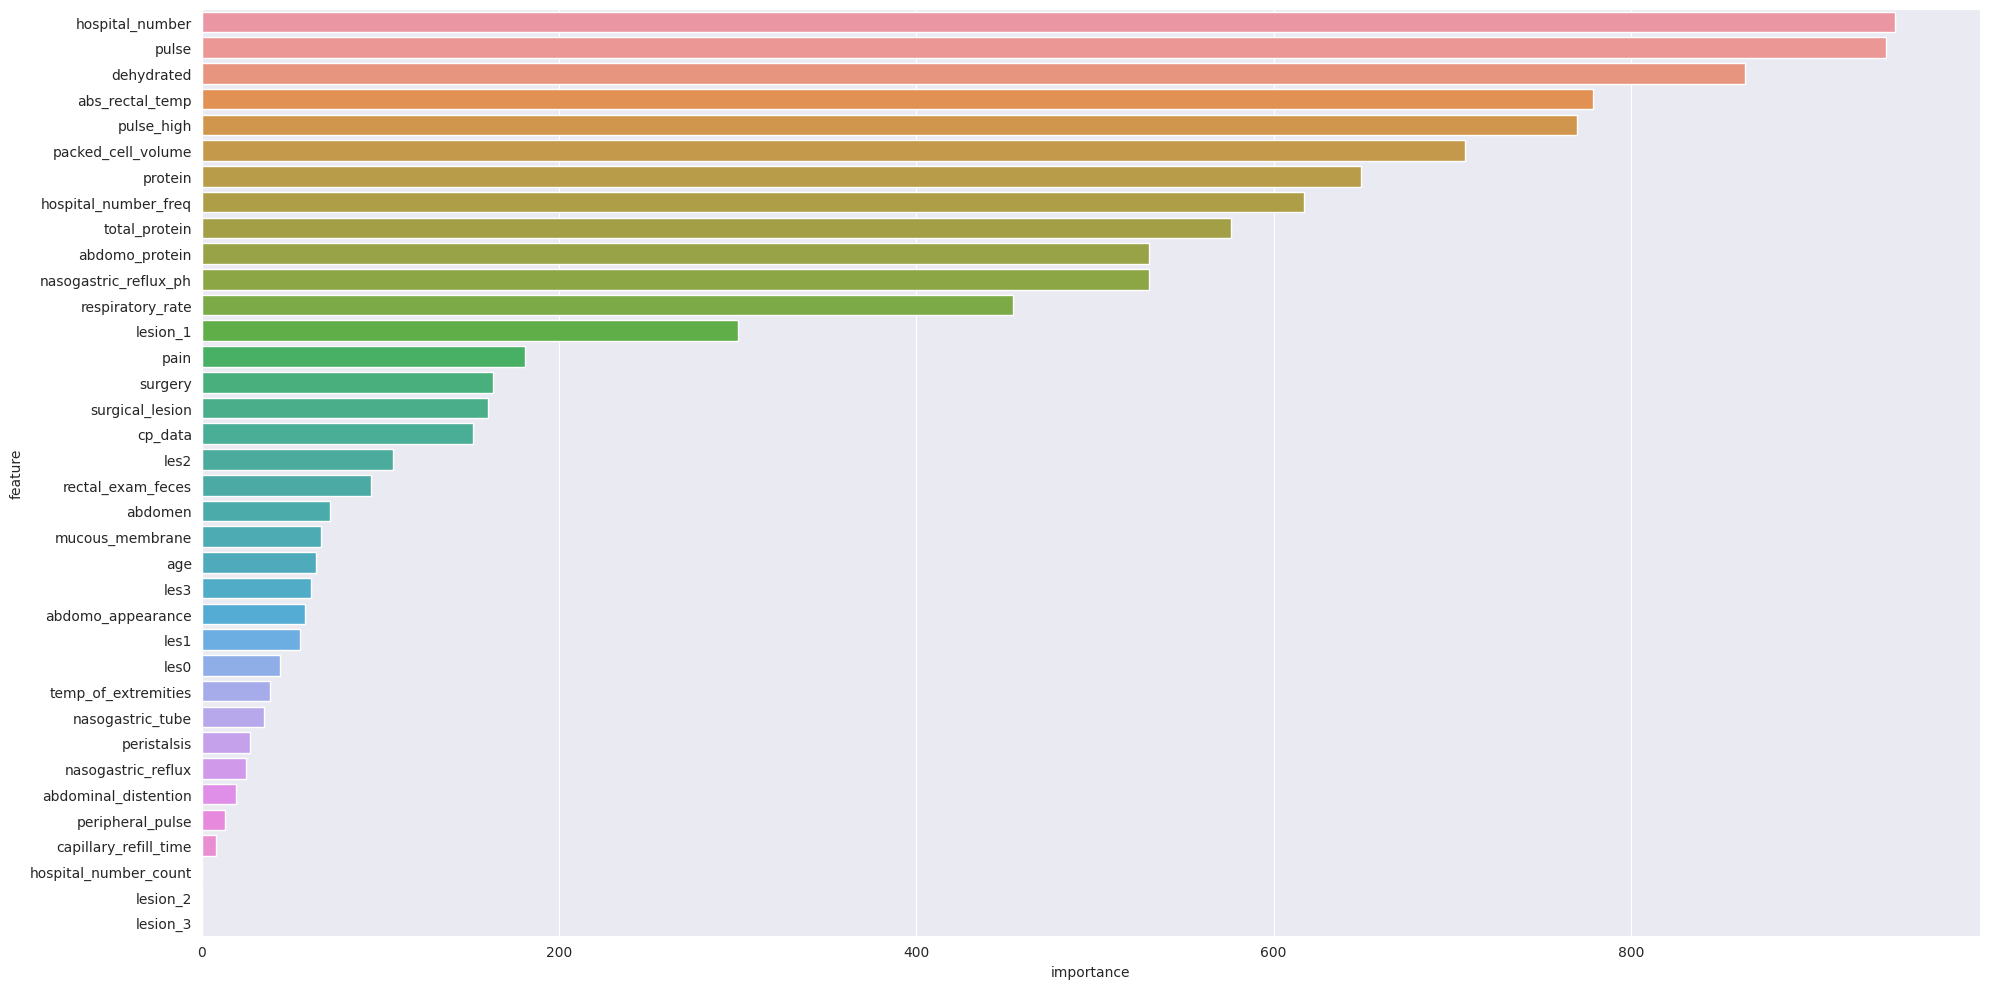

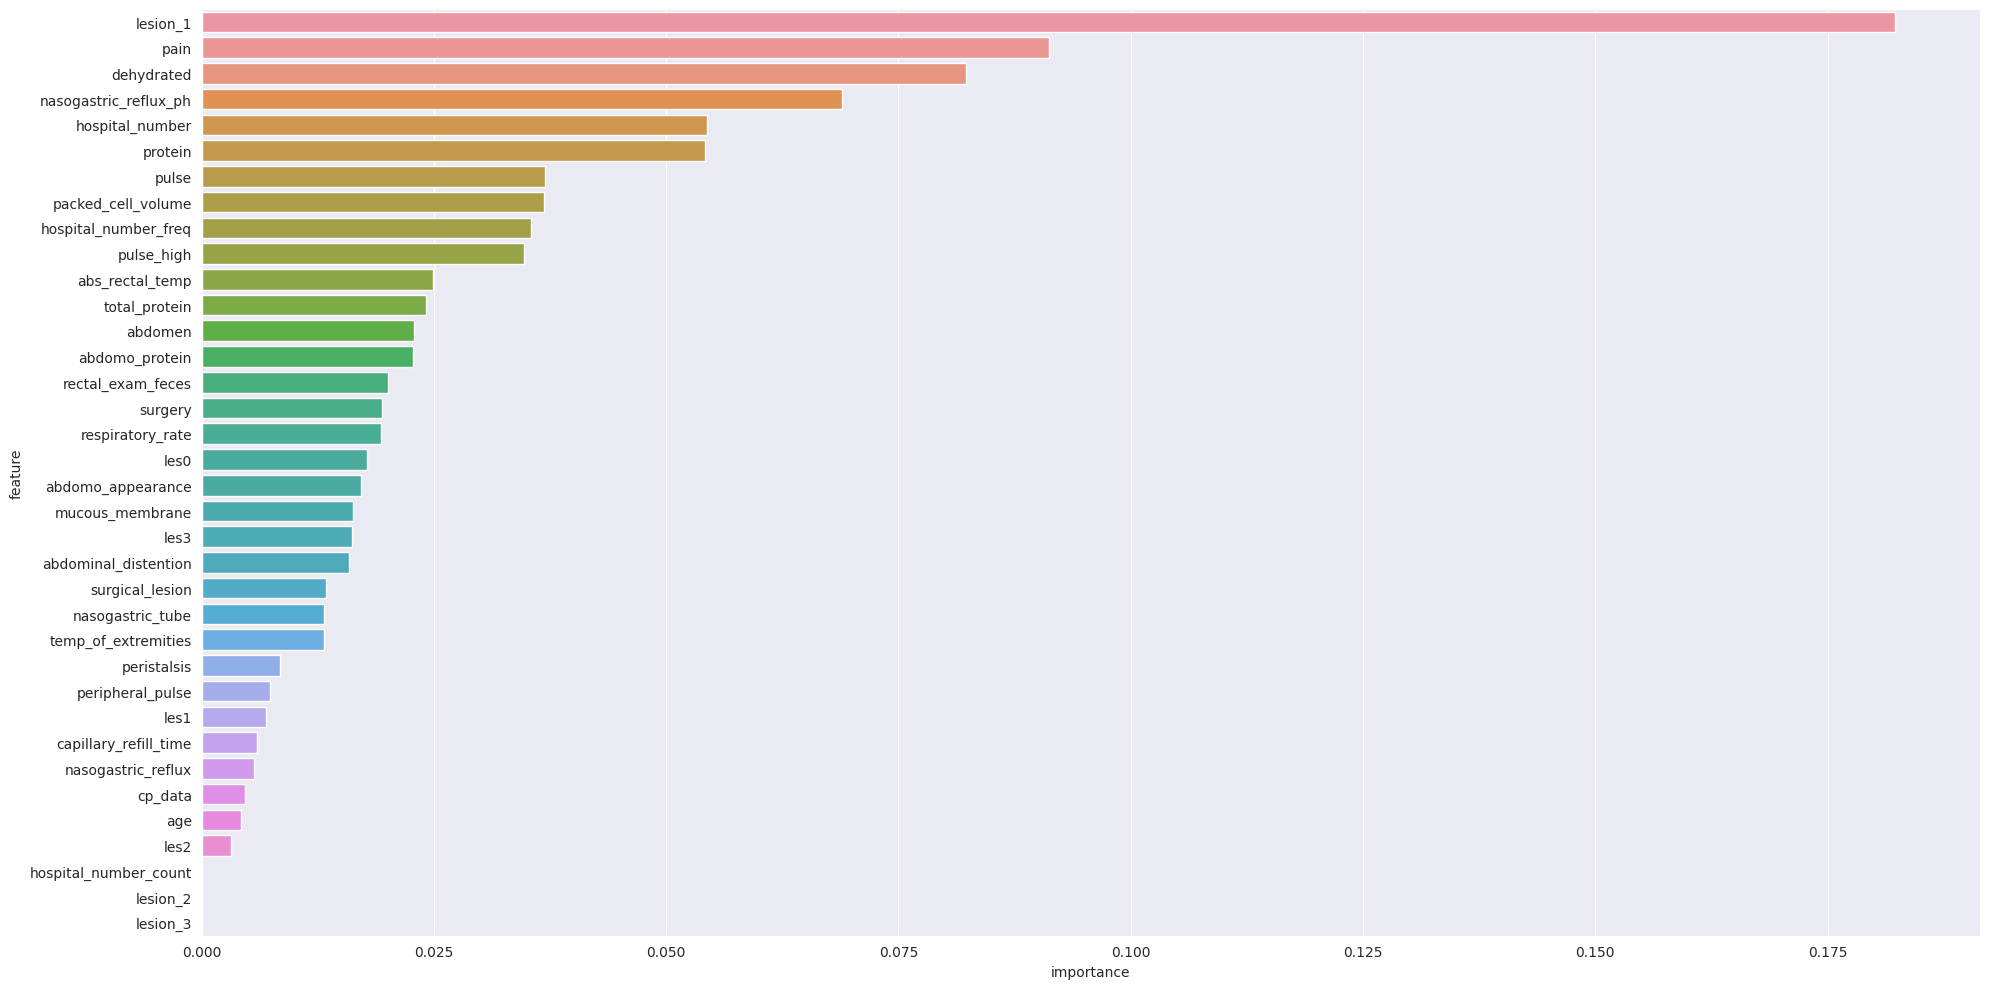

In [33]:
feat_selector = FeatureSelector(modeling_type='classification',
                                    X_train=X_train, y_train=y_train,
                                    X_test=X_test, y_test=y_test,
                                    numeric_columns=num_feats,
                                    categorical_columns=cat_feats,
                                    seed=42)

lgbm_importance_df = feat_selector.lgbm_importance(hyperparam_dict=None,
                                                   objective=None,
                                                   return_plot=True)

xgb_importance_df = feat_selector.xgb_importance(hyperparam_dict=None,
                                                   objective=None,
                                                   return_plot=True)

In [34]:
lgbm_importance_df.tail(10)

,feature,importance
26,temp_of_extremities,38
27,nasogastric_tube,35
28,peristalsis,27
29,nasogastric_reflux,25
30,abdominal_distention,19
31,peripheral_pulse,13
32,capillary_refill_time,8
33,hospital_number_count,0
34,lesion_2,0
35,lesion_3,0


In [35]:
drop_list=lgbm_importance_df["feature"][-6:]
X.drop(drop_list, axis=1, inplace=True)
X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
test_df.drop(drop_list, axis=1, inplace=True)

In [36]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.58it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.76,0.74,None,0.76,0.47
LGBMClassifier,0.76,0.73,None,0.76,0.28
ExtraTreesClassifier,0.75,0.72,None,0.75,0.24
RandomForestClassifier,0.74,0.71,None,0.74,0.42
GaussianNB,0.71,0.71,None,0.71,0.02
AdaBoostClassifier,0.72,0.70,None,0.72,0.23
SVC,0.72,0.70,None,0.72,0.11
QuadraticDiscriminantAnalysis,0.68,0.68,None,0.69,0.05
LogisticRegression,0.71,0.68,None,0.71,0.06


In [37]:
xgb_params = {
              'booster': 'gbtree', 
              'max_depth': 7, 
              'learning_rate': 0.01688121483835894, 
              'n_estimators': 540, 
              'min_child_weight': 9, 
              'gamma': 7.822265660599075e-05, 
              'subsample': 0.6635423244342881, 
              'colsample_bytree': 0.11029547391551776, 
              'reg_alpha': 0.0016867315233362798, 
              'reg_lambda': 0.0011163647216476953, 
              'eval_metric': 'mlogloss'
             }
lgb_params = {
            'n_estimators': 200,
            'max_depth': 16,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-05,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
cat_params = {
            'iterations': 200,
            'depth': 16,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'TotalF1',
            'loss_function': 'MultiClass',
            'random_state': 42,
        }

In [38]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('f1-score: ', f1_score(y_test, y_pred, average='micro')) 

f1-score:  0.761744966442953


In [39]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print('f1-score: ', f1_score(y_test, y_pred, average='micro')) 

f1-score:  0.7583892617449665


In [40]:
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

print('f1-score: ', f1_score(y_test, y_pred, average='micro')) 

Learning rate set to 0.079835
0:	learn: 1.0514627	total: 69ms	remaining: 1m 8s
1:	learn: 1.0180487	total: 73.4ms	remaining: 36.6s
2:	learn: 0.9821748	total: 76.7ms	remaining: 25.5s
3:	learn: 0.9527969	total: 80.1ms	remaining: 19.9s
4:	learn: 0.9214648	total: 83.8ms	remaining: 16.7s
5:	learn: 0.8941388	total: 86.9ms	remaining: 14.4s
6:	learn: 0.8710487	total: 90.1ms	remaining: 12.8s
7:	learn: 0.8530247	total: 93.9ms	remaining: 11.6s
8:	learn: 0.8358714	total: 97.2ms	remaining: 10.7s
9:	learn: 0.8181122	total: 101ms	remaining: 9.97s
10:	learn: 0.8014985	total: 104ms	remaining: 9.35s
11:	learn: 0.7870040	total: 107ms	remaining: 8.84s
12:	learn: 0.7740244	total: 110ms	remaining: 8.38s
13:	learn: 0.7619804	total: 115ms	remaining: 8.07s
14:	learn: 0.7517395	total: 118ms	remaining: 7.75s
15:	learn: 0.7406655	total: 122ms	remaining: 7.49s
16:	learn: 0.7307815	total: 125ms	remaining: 7.24s
17:	learn: 0.7205427	total: 129ms	remaining: 7.01s
18:	learn: 0.7142743	total: 132ms	remaining: 6.81s
19:	

## xgboost

In [41]:
def objective_xg(trial):
    
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }
    
    f1_scores = []
    preds = []

    for train_index, val_index in skf.split(X, y):
        preds = []
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf = XGBClassifier(**params)
        clf.fit(X_train, y_train, verbose=0)
        
        y_val_pred = clf.predict(X_val)
        y_test_pred = clf.predict_proba(X_test)
        preds.append(y_test_pred)

        f1_micro = f1_score(y_val, y_val_pred, average='micro')
        f1_scores.append(f1_micro)

    for fold, f1_micro in enumerate(f1_scores, 1):
        print(f"Fold {fold}: Micro F1 Score={f1_micro}")

    mean_f1_micro = sum(f1_scores) / len(f1_scores)
    print(f"Mean Micro F1 Score: {mean_f1_micro}")
    
    return mean_f1_micro

In [42]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

[I 2023-10-07 22:40:34,336] A new study created in memory with name: no-name-7671568f-c934-4d26-8d1f-3029371764d3


  0%|          | 0/50 [00:00<?, ?it/s]

Fold 1: Micro F1 Score=0.7181208053691276
Fold 2: Micro F1 Score=0.7651006711409396
Fold 3: Micro F1 Score=0.7516778523489932
Fold 4: Micro F1 Score=0.7348993288590604
Fold 5: Micro F1 Score=0.734006734006734
Mean Micro F1 Score: 0.740761078344971
Fold 1: Micro F1 Score=0.7281879194630873
Fold 2: Micro F1 Score=0.7550335570469798
Fold 3: Micro F1 Score=0.7684563758389261
Fold 4: Micro F1 Score=0.7449664429530202
Fold 5: Micro F1 Score=0.7239057239057239
Mean Micro F1 Score: 0.7441100038415475
Fold 1: Micro F1 Score=0.7348993288590604
Fold 2: Micro F1 Score=0.7751677852348994
Fold 3: Micro F1 Score=0.7550335570469798
Fold 4: Micro F1 Score=0.7449664429530202
Fold 5: Micro F1 Score=0.744107744107744
Mean Micro F1 Score: 0.7508349716403407
Fold 1: Micro F1 Score=0.7114093959731543
Fold 2: Micro F1 Score=0.7583892617449665
Fold 3: Micro F1 Score=0.7583892617449665
Fold 4: Micro F1 Score=0.7348993288590604
Fold 5: Micro F1 Score=0.7138047138047139
Mean Micro F1 Score: 0.7353783924253723
Fol

In [43]:
print('Best parameters', study_xgb.best_params)

Best parameters {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.0397520648635758, 'n_estimators': 652, 'min_child_weight': 7, 'gamma': 2.7933818052869216e-06, 'subsample': 0.7005751055299829, 'colsample_bytree': 0.08306703402271631, 'reg_alpha': 7.019270463867696e-05, 'reg_lambda': 3.652746036899068e-08, 'eval_metric': 'mlogloss'}


## lgbm

In [44]:
def objective_lgb(trial):
    """Define the objective function"""

    params = {
        'objective': trial.suggest_categorical('objective', ['multiclass']),
        'metric': trial.suggest_categorical('metric', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }
    
    f1_scores = []
    preds = []

    for train_index, val_index in skf.split(X, y):
        preds = []
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf = LGBMClassifier(**params)
        clf.fit(X_train, y_train, verbose=0)
        
        y_val_pred = clf.predict(X_val)
        y_test_pred = clf.predict_proba(X_test)
        preds.append(y_test_pred)

        f1_micro = f1_score(y_val, y_val_pred, average='micro')
        f1_scores.append(f1_micro)

    for fold, f1_micro in enumerate(f1_scores, 1):
        print(f"Fold {fold}: Micro F1 Score={f1_micro}")

    mean_f1_micro = sum(f1_scores) / len(f1_scores)
    print(f"Mean Micro F1 Score: {mean_f1_micro}")
    
    return mean_f1_micro

In [45]:
study_lgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
Fold 1: Micro F1 Score=0.738255033557047
Fold 2: Micro F1 Score=0.7684563758389261
Fold 3: Micro F1 Score=0.7348993288590604
Fold 4: Micro F1 Score=0.7281879194630873
Fold 5: Micro F1 Score=0.734006734006734
Mean Micro F1 Score: 0.740761078344971
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves.
[LightGBM] [Warning] Accuracy ma

In [46]:
# Print the best parameters
print('Best parameters', study_lgb.best_params)

Best parameters {'objective': 'multiclass', 'metric': 'multi_logloss', 'max_depth': 5, 'min_child_samples': 14, 'learning_rate': 0.030189024705377255, 'n_estimators': 1576, 'min_child_weight': 3, 'subsample': 0.5715266373723273, 'colsample_bytree': 0.28857862358036324, 'reg_alpha': 0.6610080426004742, 'reg_lambda': 0.2760940836992567, 'random_state': 42}


## Catboost

In [47]:
def objective_cat(trial):
    """Define the objective function"""

    params = {
        "iterations" : trial.suggest_int("iterations", 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        "depth" : trial.suggest_int("depth", 1, 10),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        "random_strength" : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature" : trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type" : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait" : trial.suggest_int("od_wait", 10, 50),
        "verbose" : False
        
    }

    f1_scores = []
    preds = []

    for train_index, val_index in skf.split(X, y):
        preds = []
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf = CatBoostClassifier(**params)
        clf.fit(X_train, y_train, verbose=0)
        
        y_val_pred = clf.predict(X_val)
        y_test_pred = clf.predict_proba(X_test)
        preds.append(y_test_pred)

        f1_micro = f1_score(y_val, y_val_pred, average='micro')
        f1_scores.append(f1_micro)

    for fold, f1_micro in enumerate(f1_scores, 1):
        print(f"Fold {fold}: Micro F1 Score={f1_micro}")

    mean_f1_micro = sum(f1_scores) / len(f1_scores)
    print(f"Mean Micro F1 Score: {mean_f1_micro}")
    
    return mean_f1_micro

In [48]:
study_cat = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cat.optimize(objective_cat, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

Fold 1: Micro F1 Score=0.7046979865771812
Fold 2: Micro F1 Score=0.7651006711409396
Fold 3: Micro F1 Score=0.7550335570469798
Fold 4: Micro F1 Score=0.7181208053691276
Fold 5: Micro F1 Score=0.7205387205387206
Mean Micro F1 Score: 0.7326983481345898
Fold 1: Micro F1 Score=0.7114093959731543
Fold 2: Micro F1 Score=0.7315436241610739
Fold 3: Micro F1 Score=0.7046979865771812
Fold 4: Micro F1 Score=0.7214765100671141
Fold 5: Micro F1 Score=0.7070707070707071
Mean Micro F1 Score: 0.7152396447698461
Fold 1: Micro F1 Score=0.7315436241610739
Fold 2: Micro F1 Score=0.7684563758389261
Fold 3: Micro F1 Score=0.7315436241610739
Fold 4: Micro F1 Score=0.7114093959731543
Fold 5: Micro F1 Score=0.734006734006734
Mean Micro F1 Score: 0.7353919508281924
Fold 1: Micro F1 Score=0.6677852348993288
Fold 2: Micro F1 Score=0.7449664429530202
Fold 3: Micro F1 Score=0.7315436241610739
Fold 4: Micro F1 Score=0.7080536912751678
Fold 5: Micro F1 Score=0.696969696969697
Mean Micro F1 Score: 0.7098637380516575
Fo

KeyboardInterrupt: 

In [ ]:
# Print the best parameters
print('Best parameters', study_cat.best_params)

## stacking

In [ ]:
xgb_params = {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.024076897164067537, 'n_estimators': 530, 'min_child_weight': 3, 'gamma': 1.3366163990394081e-06, 'subsample': 0.7920267162691854, 'colsample_bytree': 0.1936822335524063, 'reg_alpha': 0.9627111779348942, 'reg_lambda': 1.1176186802245266e-08, 'eval_metric': 'mlogloss'}
lgb_params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'max_depth': 6, 'min_child_samples': 5, 'learning_rate': 0.01981860392237674, 'n_estimators': 725, 'min_child_weight': 6, 'subsample': 0.988585692153749, 'colsample_bytree': 0.1609528025635198, 'reg_alpha': 0.030639364004545783, 'reg_lambda': 0.661493797134725, 'random_state': 42}
cat_params = {'iterations': 685, 'learning_rate': 0.24894290690812815, 'depth': 3, 'l2_leaf_reg': 9.4506085324804, 'bootstrap_type': 'Bayesian', 'random_strength': 3.3058042022358616, 'bagging_temperature': 8.63854259205551, 'od_type': 'IncToDec', 'od_wait': 39}

In [49]:
xgb_params = {'booster': 'gbtree', 'max_depth': 9, 'learning_rate': 0.01242061055281783, 'n_estimators': 524, 'min_child_weight': 5, 'gamma': 1.4579296269880364e-06, 'subsample': 0.6858411742920888, 'colsample_bytree': 0.1620528115237307, 'reg_alpha': 8.689264281452395e-08, 'reg_lambda': 1.0197461824998841e-08, 'eval_metric': 'mlogloss'}
lgb_params = {'objective': 'multiclass', 'metric': 'multi_logloss', 'max_depth': 5, 'min_child_samples': 14, 'learning_rate': 0.014424213512894753, 'n_estimators': 1462, 'min_child_weight': 6, 'subsample': 0.7155154634236739, 'colsample_bytree': 0.265247575929019, 'reg_alpha': 0.6870402473123021, 'reg_lambda': 0.7815394314841095, 'random_state': 42}
cat_params = {'iterations': 832, 'learning_rate': 0.06929428032483093, 'depth': 4, 'l2_leaf_reg': 8.776621232966082e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7829124038702509, 'bagging_temperature': 9.133990275267372, 'od_type': 'IncToDec', 'od_wait': 44}

In [50]:
f1_scores = []
preds = []

for train_index, val_index in skf.split(X, y):
    # preds = []
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    clf = StackingClassifier(estimators=[('cat', CatBoostClassifier(**cat_params)),
                                      ('lgbm', LGBMClassifier(**lgb_params)), 
                                      ('xgb', XGBClassifier(**xgb_params))])
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict_proba(test_df)
    preds.append(y_test_pred)

    f1_micro = f1_score(y_val, y_val_pred, average='micro')
    f1_scores.append(f1_micro)

for fold, f1_micro in enumerate(f1_scores, 1):
    print(f"Fold {fold}: Micro F1 Score={f1_micro}")

mean_f1_micro = sum(f1_scores) / len(f1_scores)
print(f"Mean Micro F1 Score: {mean_f1_micro}")

0:	learn: 1.0812284	total: 2.07ms	remaining: 1.72s
1:	learn: 1.0519677	total: 4.42ms	remaining: 1.83s
2:	learn: 1.0285407	total: 14ms	remaining: 3.87s
3:	learn: 0.9995431	total: 22.1ms	remaining: 4.57s
4:	learn: 0.9832898	total: 33.6ms	remaining: 5.56s
5:	learn: 0.9696824	total: 35.6ms	remaining: 4.89s
6:	learn: 0.9431579	total: 37.5ms	remaining: 4.42s
7:	learn: 0.9336490	total: 49.1ms	remaining: 5.06s
8:	learn: 0.9164177	total: 51.4ms	remaining: 4.7s
9:	learn: 0.8958052	total: 57.1ms	remaining: 4.69s
10:	learn: 0.8814909	total: 59.3ms	remaining: 4.43s
11:	learn: 0.8704473	total: 61.9ms	remaining: 4.23s
12:	learn: 0.8554155	total: 68.3ms	remaining: 4.3s
13:	learn: 0.8442216	total: 70.7ms	remaining: 4.13s
14:	learn: 0.8351290	total: 73ms	remaining: 3.97s
15:	learn: 0.8208600	total: 74.7ms	remaining: 3.81s
16:	learn: 0.8126797	total: 80.4ms	remaining: 3.86s
17:	learn: 0.8045470	total: 82.4ms	remaining: 3.73s
18:	learn: 0.7954296	total: 85.1ms	remaining: 3.64s
19:	learn: 0.7882674	total: 

In [51]:
# 당시 Mean Micro F1 Score는 0.7555329582175219 였습니다..

In [52]:
stack_preds = pd.DataFrame(preds[0])
stack_predictions = []

for index, row in stack_preds.iterrows():
    prediction = row.idxmax() 
    stack_predictions.append(prediction)

In [53]:
submission = pd.read_csv('./submissions/sample_submission.csv')
submission['outcome'] = stack_predictions
submission['outcome'] = submission['outcome'].map({0: 'died', 1: 'euthanized', 2: 'lived'})
submission.to_csv("./submissions/final5.csv", index=False)

In [54]:
def plot_pie_chart(data, title, ax):
    data_counts = data['outcome'].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [ (0.4, 0.76, 0.65), 'crimson',  (0.99, 0.55, 0.38)]  
    explode = (0.1, 0, 0)  

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

In [55]:
stack1_1002 = pd.read_csv('./submissions/1002_stack1 (1).csv')

In [56]:
final = pd.read_csv('./submissions/final.csv')

In [57]:
final2 = pd.read_csv('./submissions/final2.csv')

In [58]:
final3 = pd.read_csv('./submissions/final3.csv')

In [59]:
final4 = pd.read_csv('./submissions/final4.csv')

In [60]:
final5 = pd.read_csv('./submissions/final5.csv')

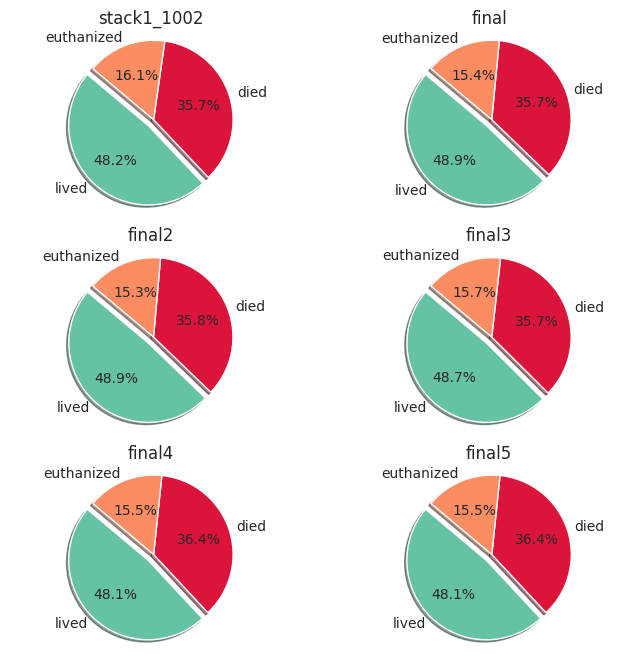

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

plot_pie_chart(stack1_1002, "stack1_1002", axes[0][0])
plot_pie_chart(final, "final", axes[0][1])
plot_pie_chart(final2, "final2", axes[1][0])
plot_pie_chart(final3, "final3", axes[1][1])
plot_pie_chart(final4, "final4", axes[2][0])
plot_pie_chart(final5, "final5", axes[2][1])